# **Ciencia y Análisis de Datos**

- Héctor Raúl Vázquez Gléz. (A00565542)
- Mario Alberto Sangines Estala (A01328170)

# **Reto : Limpieza, análisis, visualización y agrupamiento**

En el conjunto de datos encontrarás; aguas subterraneas y Aguas superficiales. Elige un tipo. A este conjunto de datos  se le realizará: 
- Limpieza de Base de Datos
- Exploración de cada Dato (auxiliate de describe(), mean(), plot, boxplot de pandas)
  - Identifica tendencias centrales, promedio, media y mediana
  - Identifica la disperción, máximo y mínimo
  - Identifica medidas de posición no centrales, Cuartíles y Outliers.
  - Identifica Correlaciones
  - Preparación de Datos
- Realiza un análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a travéz de K-means.
- Muestra tus resultados de agrupamiento de latitudes y longitudes con K-means en el mapa de México. 

Comenzaremos recuperando el conjunto de Datos del internet. Primero se descargará el archivo, luego se descomprimirá y se cargará el archivo descompreso.

In [87]:
import requests, zipfile
from io import BytesIO
import pandas as pd

url = 'https://github.com/PosgradoMNA/actividades-de-aprendizaje-HRaulVazquez/blob/main/Other/Datos_de_calidad_del_agua.zip?raw=true'
req = requests.get(url)
zipfile.ZipFile(BytesIO(req.content)).extractall('Descarga_temporal/')
df=pd.read_csv('Descarga_temporal/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv', encoding = 'latin1')


In [88]:
df.shape

(1068, 57)

In [89]:
df.head(2) #Verificamos si se cargó la información

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI


In [90]:
df_info = df.copy() #Hacemos una copia para trabajar sobre esta

Primero observamos cuantos campos nulos existen en el conjunto de Datos

In [91]:
df_info.isnull().sum().sort_values()

CLAVE                      0
CR_TOT_mg/L                0
CALIDAD_CR                 0
HG_TOT_mg/L                0
CALIDAD_HG                 0
PB_TOT_mg/L                0
CALIDAD_PB                 0
MN_TOT_mg/L                0
CALIDAD_MN                 0
FE_TOT_mg/L                0
CALIDAD_FE                 0
SEMAFORO                   0
CALIDAD_CD                 0
CUMPLE_CON_ALC             0
CUMPLE_CON_SDT_ra          0
CUMPLE_CON_SDT_salin       0
CUMPLE_CON_FLUO            0
CUMPLE_CON_DUR             0
CUMPLE_CON_CF              0
CUMPLE_CON_NO3             0
CUMPLE_CON_AS              0
CUMPLE_CON_CD              0
CUMPLE_CON_CR              0
CUMPLE_CON_HG              0
CUMPLE_CON_PB              0
CUMPLE_CON_COND            0
CUMPLE_CON_MN              0
CD_TOT_mg/L                0
AS_TOT_mg/L                0
SITIO                      0
ORGANISMO_DE_CUENCA        0
ESTADO                     0
MUNICIPIO                  0
ACUIFERO                   0
SUBTIPO       

In [92]:
#La columna "SDT_mg/L" no tiene información, nos desaremos de ella
df_info.drop("SDT_mg/L", axis=1, inplace= True)
#Mientras que la columna "Contaminantes" tiene solo el 40.6% de la información
#Además, no estamos muy seguros de como analizarla, así que tambaién la retiramos por el momento
df_info.drop("CONTAMINANTES", axis=1, inplace= True)

Vamos a verificar el Tipo de dato de Cada columna, con el fin de asignar el tipo de dato correcto.

In [93]:
df_info.dtypes

CLAVE                    object
SITIO                    object
ORGANISMO_DE_CUENCA      object
ESTADO                   object
MUNICIPIO                object
ACUIFERO                 object
SUBTIPO                  object
LONGITUD                float64
LATITUD                 float64
PERIODO                   int64
ALC_mg/L                float64
CALIDAD_ALC              object
CONDUCT_mS/cm           float64
CALIDAD_CONDUC           object
SDT_M_mg/L               object
CALIDAD_SDT_ra           object
CALIDAD_SDT_salin        object
FLUORUROS_mg/L           object
CALIDAD_FLUO             object
DUR_mg/L                 object
CALIDAD_DUR              object
COLI_FEC_NMP/100_mL      object
CALIDAD_COLI_FEC         object
N_NO3_mg/L               object
CALIDAD_N_NO3            object
AS_TOT_mg/L              object
CALIDAD_AS               object
CD_TOT_mg/L              object
CALIDAD_CD               object
CR_TOT_mg/L              object
CALIDAD_CR               object
HG_TOT_m

Después de examinar la información, creemos que pandas no asigna correctamente el tipo de datos debido a que en las columnas que deberían de ser numéricas existen valores con el sigon "<" y en las columnas que deberían de ser String, no las reconoce debido a los campos nulos. (O sea es nuestra teoría)

Por tanto, empezaremos con este aspecto de la limpieza;
- Primero, categorizaremos las columnas en numéricas, categóricas y seleccionaremos nuestra columna de salida.
- Luego, en nuestras columnas numéricas cambiaremos los valores con el signo "<" al número inmediato inferior y cambiaremos le tipo de dato de la columna a int o float según corresponda.

In [94]:
#Consultamos el nombre de todas las columnas hasta ahora
df_info.columns

Index(['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
       'ACUIFERO', 'SUBTIPO', 'LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L',
       'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC', 'SDT_M_mg/L',
       'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'FLUORUROS_mg/L', 'CALIDAD_FLUO',
       'DUR_mg/L', 'CALIDAD_DUR', 'COLI_FEC_NMP/100_mL', 'CALIDAD_COLI_FEC',
       'N_NO3_mg/L', 'CALIDAD_N_NO3', 'AS_TOT_mg/L', 'CALIDAD_AS',
       'CD_TOT_mg/L', 'CALIDAD_CD', 'CR_TOT_mg/L', 'CALIDAD_CR', 'HG_TOT_mg/L',
       'CALIDAD_HG', 'PB_TOT_mg/L', 'CALIDAD_PB', 'MN_TOT_mg/L', 'CALIDAD_MN',
       'FE_TOT_mg/L', 'CALIDAD_FE', 'SEMAFORO', 'CUMPLE_CON_ALC',
       'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin',
       'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR', 'CUMPLE_CON_CF', 'CUMPLE_CON_NO3',
       'CUMPLE_CON_AS', 'CUMPLE_CON_CD', 'CUMPLE_CON_CR', 'CUMPLE_CON_HG',
       'CUMPLE_CON_PB', 'CUMPLE_CON_MN', 'CUMPLE_CON_FE'],
      dtype='object')

In [95]:
#Separación de Columnas por Tipo
columnas_numericas = ["PERIODO","ALC_mg/L","CONDUCT_mS/cm","SDT_M_mg/L","FLUORUROS_mg/L","DUR_mg/L","COLI_FEC_NMP/100_mL","N_NO3_mg/L","AS_TOT_mg/L","CD_TOT_mg/L","CR_TOT_mg/L","HG_TOT_mg/L","PB_TOT_mg/L","MN_TOT_mg/L","FE_TOT_mg/L"]
columnas_categoricas = ["SITIO","ORGANISMO_DE_CUENCA","MUNICIPIO","ESTADO","ACUIFERO","SUBTIPO","CALIDAD_ALC","CALIDAD_CONDUC","CALIDAD_SDT_ra","CALIDAD_SDT_salin","CALIDAD_FLUO","CALIDAD_DUR","CALIDAD_COLI_FEC","CALIDAD_N_NO3","CALIDAD_AS","CALIDAD_CD","CALIDAD_CR","CALIDAD_HG","CALIDAD_PB","CALIDAD_MN","CALIDAD_FE","CUMPLE_CON_ALC","CUMPLE_CON_COND","CUMPLE_CON_SDT_ra","CUMPLE_CON_SDT_salin","CUMPLE_CON_FLUO","CUMPLE_CON_DUR","CUMPLE_CON_CF","CUMPLE_CON_NO3","CUMPLE_CON_AS","CUMPLE_CON_CD","CUMPLE_CON_CR","CUMPLE_CON_HG","CUMPLE_CON_PB","CUMPLE_CON_MN","CUMPLE_CON_FE"]
Columna_salida = ["SEMAFORO"]

In [96]:
#Se define una función para buscar un valor y reemplazarlo por otro
def reemplazaValor (dataSet, columna, Vold, Vnew):
  dataSet[columna] = dataSet[columna].str.replace(Vold,Vnew)

In [97]:
columnas_numericas = ["PERIODO","ALC_mg/L","CONDUCT_mS/cm","SDT_M_mg/L","FLUORUROS_mg/L","DUR_mg/L","COLI_FEC_NMP/100_mL","N_NO3_mg/L","AS_TOT_mg/L","CD_TOT_mg/L","CR_TOT_mg/L","HG_TOT_mg/L","PB_TOT_mg/L","MN_TOT_mg/L","FE_TOT_mg/L"]


#Se reemplazan los valores y se cambia el tipo de datos de las columnas
df_info['PERIODO'] = df_info['PERIODO'].astype(int)

# '<25' SDT_M_mg/L
df_info['SDT_M_mg/L'] = df_info['SDT_M_mg/L'].astype('str')
reemplazaValor(df_info, "SDT_M_mg/L", '<25', "24")
df_info['SDT_M_mg/L'] = df_info['SDT_M_mg/L'].astype(float)

# '<0.2' FLUORUROS_mg/L
df_info['FLUORUROS_mg/L'] = df_info['FLUORUROS_mg/L'].astype('str')
reemplazaValor(df_info, "FLUORUROS_mg/L", '<0.2', "0.19")
df_info['FLUORUROS_mg/L'] = df_info['FLUORUROS_mg/L'].astype(float)

# '<20' DUR_mg/L
df_info['DUR_mg/L'] = df_info['DUR_mg/L'].astype('str')
reemplazaValor(df_info, "DUR_mg/L", '<20', "19")
df_info['DUR_mg/L'] = df_info['DUR_mg/L'].astype(float)

# '<1.1' COLI_FEC_NMP/100_mL
df_info['COLI_FEC_NMP/100_mL'] = df_info['COLI_FEC_NMP/100_mL'].astype('str')
reemplazaValor(df_info, "COLI_FEC_NMP/100_mL", '<1.1', "1.09")
df_info['COLI_FEC_NMP/100_mL'] = df_info['COLI_FEC_NMP/100_mL'].astype(float)

# '<0.02' N_NO3_mg/L
df_info['N_NO3_mg/L'] = df_info['N_NO3_mg/L'].astype('str')
reemplazaValor(df_info, "N_NO3_mg/L", '<0.02', "0.019")
df_info['N_NO3_mg/L'] = df_info['N_NO3_mg/L'].astype(float)

# '<0.01' AS_TOT_mg/L
df_info['AS_TOT_mg/L'] = df_info['AS_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "AS_TOT_mg/L", '<0.01', "0.009")
df_info['AS_TOT_mg/L'] = df_info['AS_TOT_mg/L'].astype(float)

# '<0.003' CD_TOT_mg/L
df_info['CD_TOT_mg/L'] = df_info['CD_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "CD_TOT_mg/L", '<0.003', "0.0029")
df_info['CD_TOT_mg/L'] = df_info['CD_TOT_mg/L'].astype(float)

# '<0.005' CR_TOT_mg/L
df_info['CR_TOT_mg/L'] = df_info['CR_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "CR_TOT_mg/L", '<0.005', "0.0049")
df_info['CR_TOT_mg/L'] = df_info['CR_TOT_mg/L'].astype(float)

# '<0.0005' HG_TOT_mg/L
df_info['HG_TOT_mg/L'] = df_info['HG_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "HG_TOT_mg/L", '<0.0005', "0.00049")
df_info['HG_TOT_mg/L'] = df_info['HG_TOT_mg/L'].astype(float)

# '<0.005' PB_TOT_mg/L
df_info['PB_TOT_mg/L'] = df_info['PB_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "PB_TOT_mg/L", '<0.005', "0.0049")
df_info['PB_TOT_mg/L'] = df_info['PB_TOT_mg/L'].astype(float)

# '<0.0015' MN_TOT_mg/L
df_info['MN_TOT_mg/L'] = df_info['MN_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "MN_TOT_mg/L", '<0.0015', "0.0014")
df_info['MN_TOT_mg/L'] = df_info['MN_TOT_mg/L'].astype(float)

# '<0.025' FE_TOT_mg/L
df_info['FE_TOT_mg/L'] = df_info['FE_TOT_mg/L'].astype('str')
reemplazaValor(df_info, "FE_TOT_mg/L", '<0.025', "0.024")
df_info['FE_TOT_mg/L'] = df_info['FE_TOT_mg/L'].astype(float)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Después de este tratamiento, Recontamos los números nulos restantes

In [98]:
df_info.isnull().sum().sort_values()

CLAVE                   0
CR_TOT_mg/L             0
CALIDAD_CR              0
HG_TOT_mg/L             0
CALIDAD_HG              0
PB_TOT_mg/L             0
CALIDAD_PB              0
MN_TOT_mg/L             0
CALIDAD_MN              0
FE_TOT_mg/L             0
CALIDAD_FE              0
SEMAFORO                0
CALIDAD_CD              0
CUMPLE_CON_ALC          0
CUMPLE_CON_SDT_ra       0
CUMPLE_CON_SDT_salin    0
CUMPLE_CON_FLUO         0
CUMPLE_CON_DUR          0
CUMPLE_CON_CF           0
CUMPLE_CON_NO3          0
CUMPLE_CON_AS           0
CUMPLE_CON_CD           0
CUMPLE_CON_CR           0
CUMPLE_CON_HG           0
CUMPLE_CON_PB           0
CUMPLE_CON_COND         0
CUMPLE_CON_MN           0
CD_TOT_mg/L             0
AS_TOT_mg/L             0
SITIO                   0
ORGANISMO_DE_CUENCA     0
ESTADO                  0
MUNICIPIO               0
ACUIFERO                0
SUBTIPO                 0
LONGITUD                0
LATITUD                 0
PERIODO                 0
CALIDAD_AS  

Nos damos cuenta de que en el peor de los casos nos quedan 16 registros con variables vacías, Hemos decidido eliminarlos con el fin de no meter información con ruido al conjunto de datos.

In [99]:
df_info.dropna(inplace=True)
df_info.shape

(1054, 55)

# **Exploración de Datos**

El objetivo de esta tabla es describir la información contenida en cada columna:

In [100]:
# Se tiene que tener en cuenta que aquí solo se muestran las columnas numéricas
df_info.describe().T

,count,mean,std,min,25%,50%,75%,max
LONGITUD,1054.0,-101.848270,6.697568,-116.66425,-105.385170,-102.170665,-98.971268,-86.864120
LATITUD,1054.0,23.161796,3.875005,14.56115,20.224857,22.640705,25.508770,32.677713
PERIODO,1054.0,2020.000000,0.000000,2020.00000,2020.000000,2020.000000,2020.000000,2020.000000
ALC_mg/L,1054.0,234.695266,111.147849,26.64000,164.257500,215.825000,292.930000,1650.000000
CONDUCT_mS/cm,1054.0,1142.726471,1248.990617,110.00000,506.000000,820.000000,1328.000000,18577.000000
SDT_M_mg/L,1054.0,896.945797,2765.757924,101.20000,338.050000,551.400000,915.600000,82170.000000
FLUORUROS_mg/L,1054.0,1.077048,1.931890,0.19000,0.269475,0.506950,1.142400,34.803300
DUR_mg/L,1054.0,349.869865,360.981883,19.00000,121.512000,245.994450,455.617200,3810.692200
COLI_FEC_NMP/100_mL,1054.0,359.727249,2065.706973,1.09000,1.090000,1.090000,10.750000,24196.000000
N_NO3_mg/L,1054.0,4.321591,8.378363,0.01900,0.651667,2.082916,5.190385,121.007813


Para obtener graficas que tengan mayor coeherncia de una columna contra otra, utilizaremos el escalador MinMax para poner los datos de las columnas numpericas en la misma escala.

Se grafica los Boxplot de las columnas numéricas

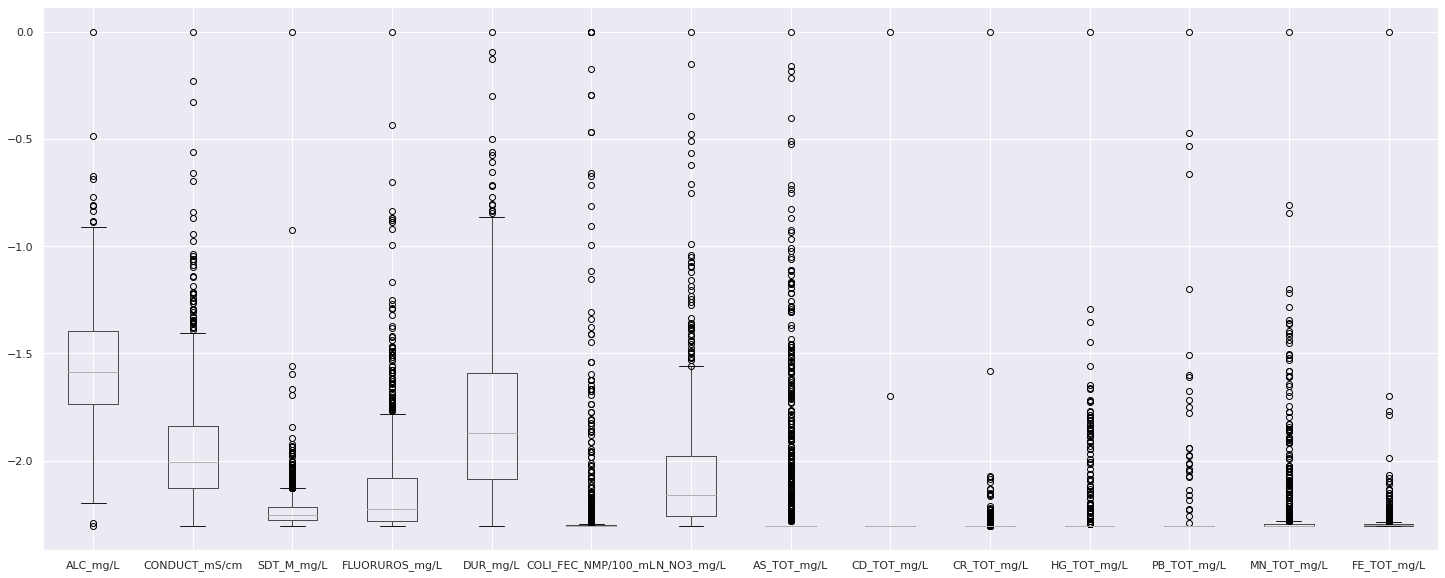

In [101]:
#Se Transforman los datos de las columnas numéricas
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


scaler = MinMaxScaler(feature_range=(0.1,1))
scaler.fit(df_info[columnas_numericas])
df_transf = pd.DataFrame(scaler.transform(df_info[columnas_numericas]))
df_transf.columns = columnas_numericas
df_transf.drop("PERIODO", axis=1, inplace=True)

#Para mejorar la distribución de la información, hemos decidido aplicar la función "log"
#a las columnas numéricas
df_transf_log = np.log(df_transf)

df_transf_log.boxplot(figsize=(25,10))


Para aclarar un poco mejor esta gráfica de caja, vamos a compararla contra los histogramas de cada columna

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3498a7fc50>,
      dtype=object)

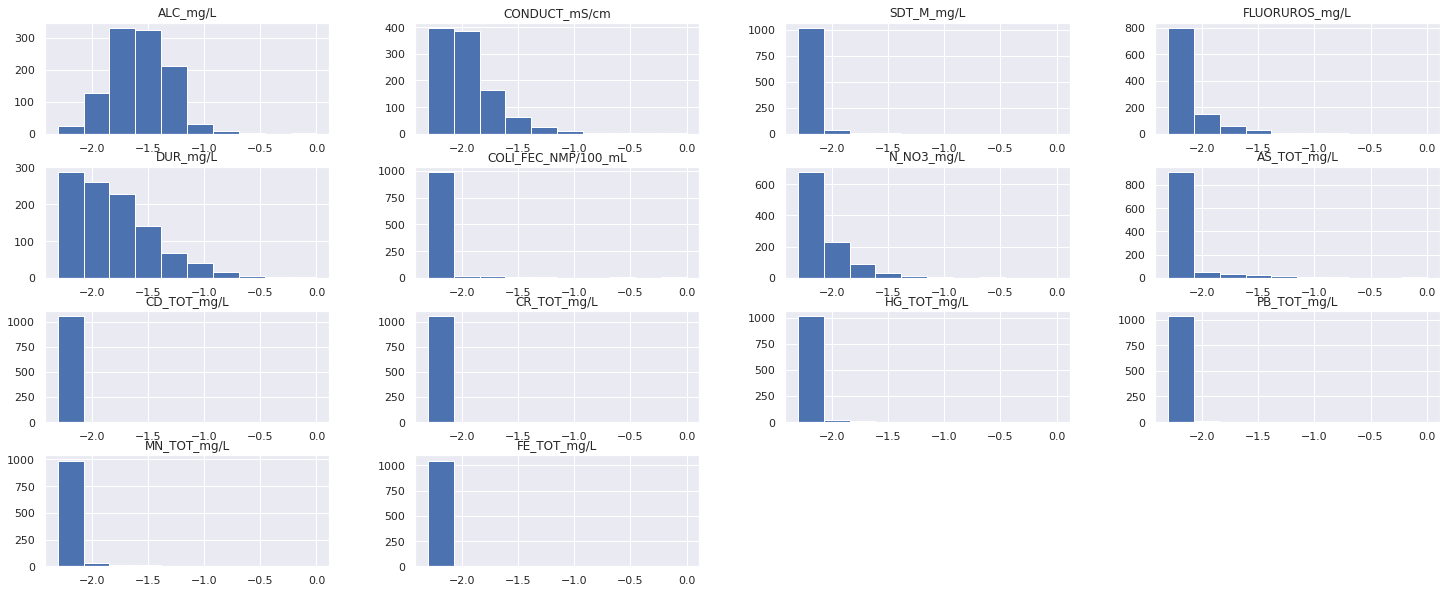

In [102]:
df_transf_log.hist( bins=10 ,figsize=(25,10))

Con la siguiente gráfica se explora la posible correlación entre las columnas:

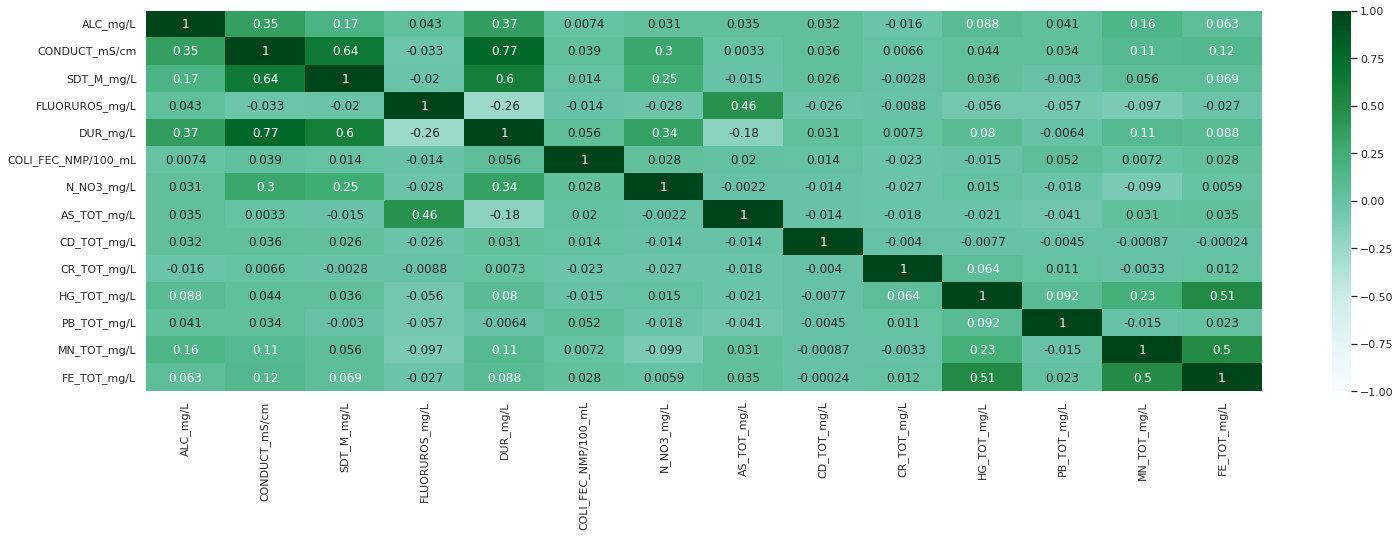

In [103]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(25,7)})
sns.heatmap(df_transf_log.corr(), vmin = -1, vmax = 1,  annot= True , cmap="BuGn")


# **Exploración de Datos por medio de K-Means**

Para esta sección, solo trabajaremos con la información de las coordenadas de cada registro.

In [104]:
from sklearn.cluster import KMeans

df_coordenadas = df_info[['LATITUD','LONGITUD']]


#Empezaremos por saber cuántos clusters nos da el resultado más "aceptable" para el método KMeans
#Haremos 10 iteraciones y almacenaremos los resultados con el "Squared Error"
k_range = range(1,15)
sse = []

for k in k_range:
  km  = KMeans(n_clusters= k)
  km.fit(df_coordenadas)
  sse.append(km.inertia_)

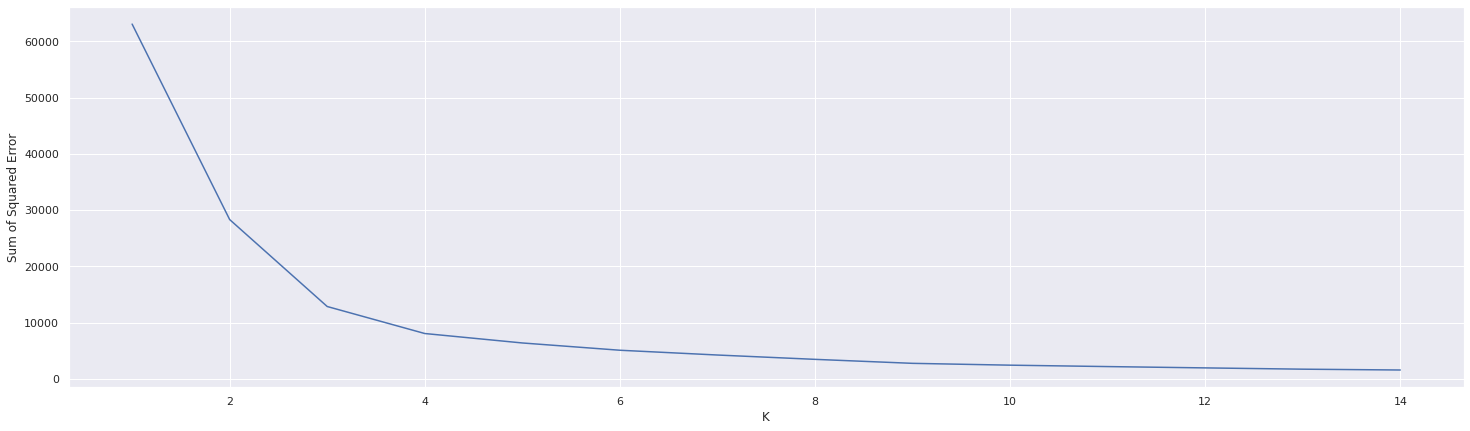

In [105]:
#Para elegir, usaremos la relga del "Codo"
#Que quiere decir que elegiremos la iteración donde forma un codo en 
#la gráfica
plt.xlabel("K")
plt.ylabel("Sum of Squared Error")
plt.plot(k_range,sse)

Según la gráfica el "Codo" se encuentra en el 3, por tanto el número de clusters óptimo es 3. Y se calcularán los puntos de los centroides. 

In [106]:
#Declaramos el modelo con el no. de cluster que encontramos
# Y hacemos la predición
model = KMeans(n_clusters=3, max_iter=1000, random_state=0)
y_pred = model.fit_predict(df_coordenadas)
#scaler.fit(y_pred.reshape(-1, 1))
#y_pred = scaler.transform(y_pred.reshape(-1, 1))
df_centers = pd.DataFrame(model.cluster_centers_)
df_centers.columns = df_coordenadas.columns
df_centers #Guardamos las coordenadas de los centroides en un dataframe

,LATITUD,LONGITUD
0,22.271624,-101.715581
1,19.475165,-90.698434
2,28.420375,-110.740896


Vamos a graficar los puntos de los registros junto con los centroides

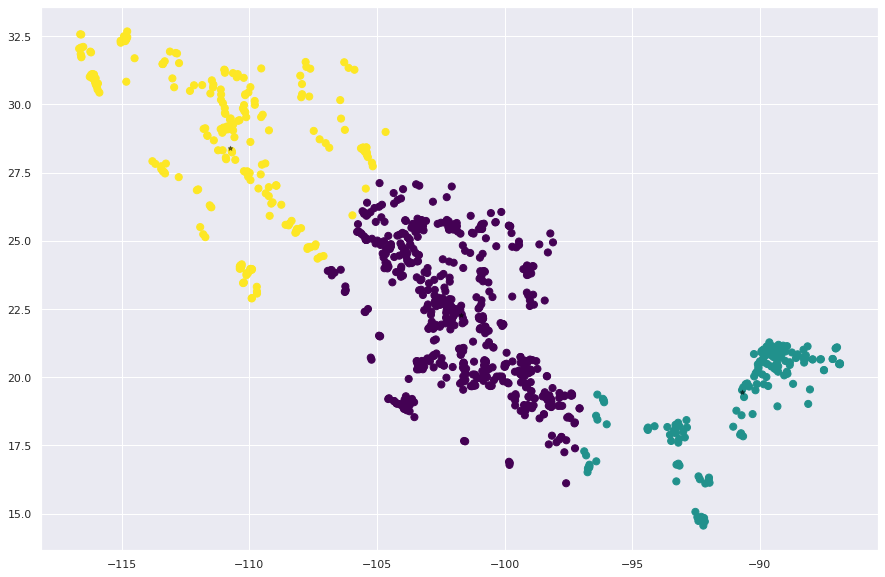

In [107]:
sns.set(rc = {'figure.figsize':(15,10)})
plt.scatter(df_coordenadas["LONGITUD"], df_coordenadas["LATITUD"], c=y_pred, s=50, cmap='viridis')
plt.scatter(df_centers["LONGITUD"], df_centers["LATITUD"], c='black',marker="*", s=20, alpha=.5);

Exploramos la posibilidad de tener 20 centros (Clusters) con K-Means

In [108]:
#Declaramos el modelo con el no. de cluster que encontramos
# Y hacemos la predición
model = KMeans(n_clusters=20, max_iter=1000, random_state=0)
y_pred = model.fit_predict(df_coordenadas)
#scaler.fit(y_pred.reshape(-1, 1))
#y_pred = scaler.transform(y_pred.reshape(-1, 1))
df_centers = pd.DataFrame(model.cluster_centers_)
df_centers.columns = df_coordenadas.columns
df_centers

,LATITUD,LONGITUD
0,25.391111,-101.627494
1,20.578108,-89.160918
2,29.714956,-110.788955
3,19.494437,-98.899276
4,23.772386,-110.101805
5,19.960125,-103.573754
6,18.100976,-97.108362
7,24.963808,-106.061808
8,17.944769,-92.861587
9,31.633190,-115.251956


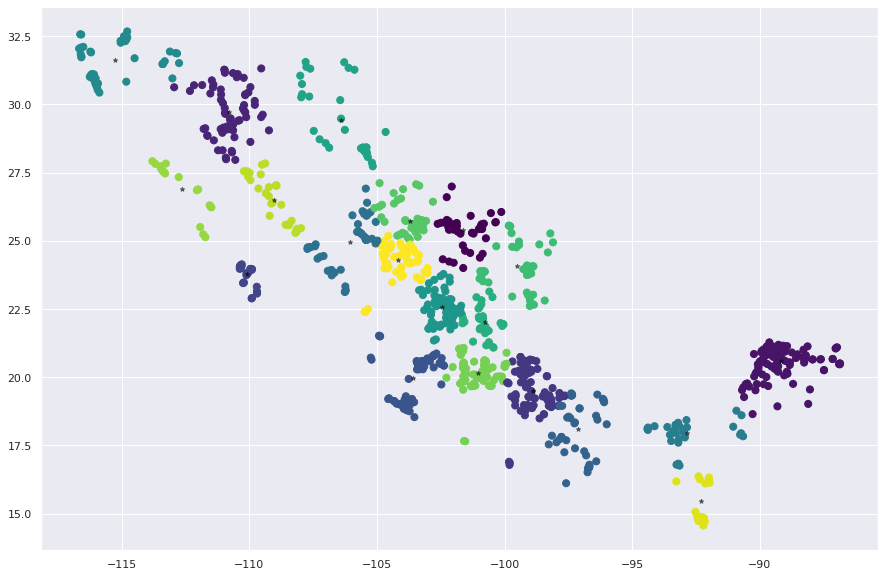

In [109]:
sns.set(rc = {'figure.figsize':(15,10)})
plt.scatter(df_coordenadas["LONGITUD"], df_coordenadas["LATITUD"], c=y_pred, s=50, cmap='viridis')
plt.scatter(df_centers["LONGITUD"], df_centers["LATITUD"], c='black',marker="*", s=20, alpha=.5);

Vamos a preparar el dataframe para ver una gráfica que muestre el semáforo también:

In [110]:
df_coordenadas["Cluster"] = y_pred
df_coordenadas["SEMAFORO"] = df_info["SEMAFORO"]

dfVerde = df_coordenadas[df_coordenadas.SEMAFORO == "Verde"]
dfAmarillo = df_coordenadas[df_coordenadas.SEMAFORO == "Amarillo"]
dfRojo = df_coordenadas[df_coordenadas.SEMAFORO == "Rojo"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


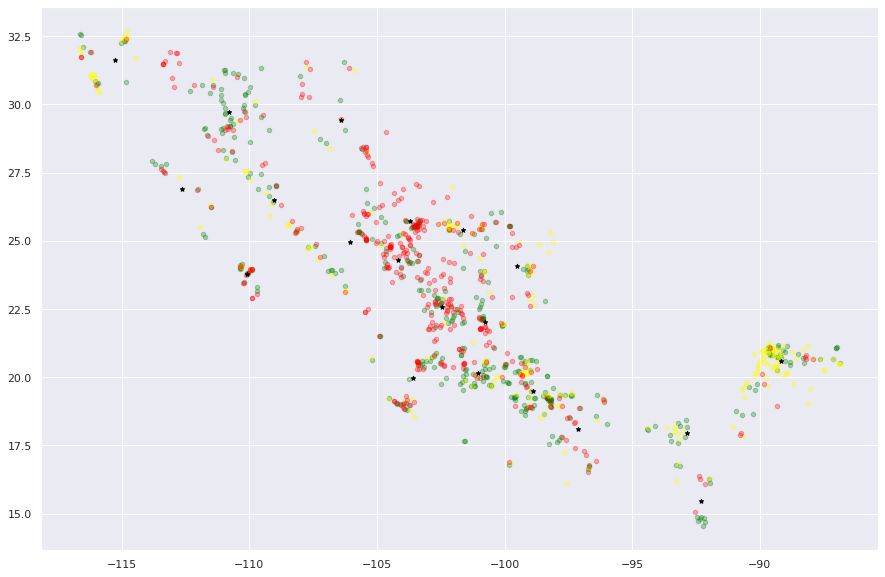

In [111]:
plt.scatter(dfVerde["LONGITUD"], dfVerde["LATITUD"], c='green', s=20, alpha=.3);
plt.scatter(dfAmarillo["LONGITUD"], dfAmarillo["LATITUD"], c='yellow', s=20, alpha=.3);
plt.scatter(dfRojo["LONGITUD"], dfRojo["LATITUD"], c='red', s=20, alpha=.3);
plt.scatter(df_centers["LONGITUD"], df_centers["LATITUD"], c='black',marker="*", s=20);

Ahora, vamos a hacer el intento de sacar la zona con mayor contaminación (los 2 cluster más contaminados) y la zona menos contaminada (los dos clusters menos contaminados)

Para esto vamos a calcular los porcentajes de los colores del semáforo por cluster.

In [112]:
#Hacemos una función que nos ayudará definir los porcentajes
def getPercentajes(dataframe):
  total = int(dataframe.shape[0])
  V = int(dataframe[dataframe.SEMAFORO == "Verde"].shape[0])
  A = int(dataframe[dataframe.SEMAFORO == "Amarillo"].shape[0])
  R = int(dataframe[dataframe.SEMAFORO == "Rojo"].shape[0])
  V = (V*100)/total
  A = (A*100)/total
  R = (R*100)/total

  return V,A,R

In [113]:
df0 = df_coordenadas[df_coordenadas.Cluster == 0]
df1 = df_coordenadas[df_coordenadas.Cluster == 1]
df2 = df_coordenadas[df_coordenadas.Cluster == 2]
df3 = df_coordenadas[df_coordenadas.Cluster == 3]
df4 = df_coordenadas[df_coordenadas.Cluster == 4]
df5 = df_coordenadas[df_coordenadas.Cluster == 5]
df6 = df_coordenadas[df_coordenadas.Cluster == 6]
df7 = df_coordenadas[df_coordenadas.Cluster == 7]
df8 = df_coordenadas[df_coordenadas.Cluster == 8]
df9 = df_coordenadas[df_coordenadas.Cluster == 9]
df10 = df_coordenadas[df_coordenadas.Cluster == 10]
df11 = df_coordenadas[df_coordenadas.Cluster == 11]
df12 = df_coordenadas[df_coordenadas.Cluster == 12]
df13 = df_coordenadas[df_coordenadas.Cluster == 13]
df14 = df_coordenadas[df_coordenadas.Cluster == 14]
df15 = df_coordenadas[df_coordenadas.Cluster == 15]
df16 = df_coordenadas[df_coordenadas.Cluster == 16]
df17 = df_coordenadas[df_coordenadas.Cluster == 17]
df18 = df_coordenadas[df_coordenadas.Cluster == 18]
df19 = df_coordenadas[df_coordenadas.Cluster == 19]

Reporte = pd.DataFrame([])
Reporte.Columns = ['Cluster','Verde','Amarillo','Rojo']

Verde,Amarillo,Rojo = getPercentajes(df0)
new_row = {'Cluster':'0','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df1)
new_row = {'Cluster':'1','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df2)
new_row = {'Cluster':'2','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df3)
new_row = {'Cluster':'3','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df4)
new_row = {'Cluster':'4','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df5)
new_row = {'Cluster':'5','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df6)
new_row = {'Cluster':'6','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df7)
new_row = {'Cluster':'7','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df8)
new_row = {'Cluster':'8','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df9)
new_row = {'Cluster':'9','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df10)
new_row = {'Cluster':'10','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df11)
new_row = {'Cluster':'11','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df12)
new_row = {'Cluster':'12','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df13)
new_row = {'Cluster':'13','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df14)
new_row = {'Cluster':'14','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df15)
new_row = {'Cluster':'15','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df16)
new_row = {'Cluster':'16','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df17)
new_row = {'Cluster':'17','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df18)
new_row = {'Cluster':'18','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)
Verde,Amarillo,Rojo = getPercentajes(df19)
new_row = {'Cluster':'19','Verde':Verde, 'Amarillo':Amarillo, 'Rojo':Rojo}
Reporte = Reporte.append(new_row, ignore_index=True)

Reporte.sort_values(by="Rojo").round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,Cluster,Verde,Amarillo,Rojo
1,1,32.77,60.50,6.72
8,8,53.57,39.29,7.14
3,3,56.36,25.45,18.18
15,15,57.75,16.90,25.35
2,2,68.18,6.06,25.76
18,18,60.00,13.33,26.67
17,17,35.48,35.48,29.03
16,16,52.94,17.65,29.41
9,9,23.40,46.81,29.79
13,13,31.82,36.36,31.82


In [114]:
Reporte.sort_values(by="Verde").round(2)

,Cluster,Verde,Amarillo,Rojo
19,19,22.22,1.59,76.19
11,11,22.58,16.13,61.29
9,9,23.40,46.81,29.79
0,0,25.00,38.46,36.54
14,14,29.51,1.64,68.85
13,13,31.82,36.36,31.82
1,1,32.77,60.50,6.72
10,10,34.72,2.78,62.50
17,17,35.48,35.48,29.03
7,7,40.00,18.00,42.00


Con los porcentajes definidos, vamos a graficar los dos cluster más contaminados y los dos menos contaminados.

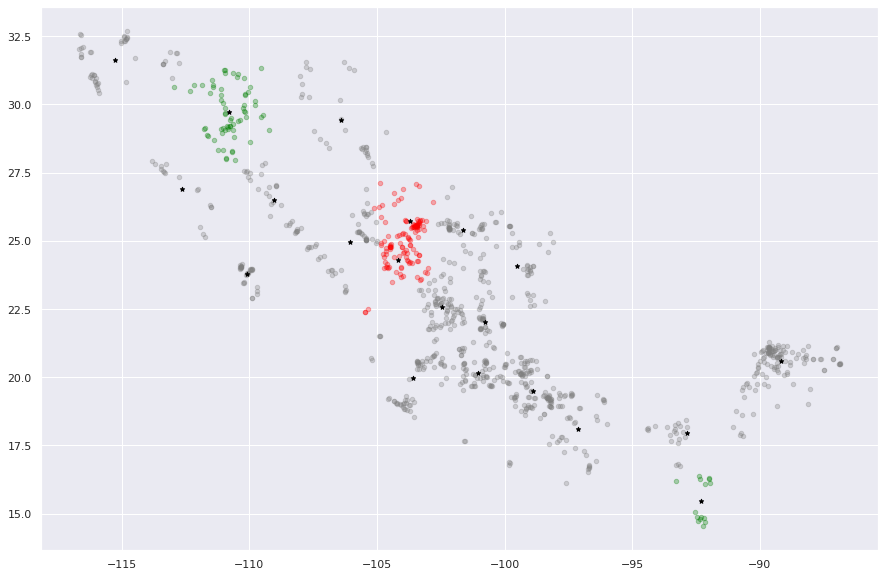

In [115]:
plt.scatter(df0["LONGITUD"], df0["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df1["LONGITUD"], df1["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df2["LONGITUD"], df2["LATITUD"], c='green', s=20, alpha=.3);
plt.scatter(df3["LONGITUD"], df3["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df4["LONGITUD"], df4["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df5["LONGITUD"], df5["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df6["LONGITUD"], df6["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df7["LONGITUD"], df7["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df8["LONGITUD"], df8["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df9["LONGITUD"], df9["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df10["LONGITUD"], df10["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df11["LONGITUD"], df11["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df12["LONGITUD"], df12["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df13["LONGITUD"], df13["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df14["LONGITUD"], df14["LATITUD"], c='red', s=20, alpha=.3);
plt.scatter(df15["LONGITUD"], df15["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df16["LONGITUD"], df16["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df17["LONGITUD"], df17["LATITUD"], c='gray', s=20, alpha=.3);
plt.scatter(df18["LONGITUD"], df18["LATITUD"], c='green', s=20, alpha=.3);
plt.scatter(df19["LONGITUD"], df19["LATITUD"], c='red', s=20, alpha=.3);
plt.scatter(df_centers["LONGITUD"], df_centers["LATITUD"], c='black',marker="*", s=20);

Y así obtenemos nuestros resultados

### Reto 2: Clasificación - Ensambles y Presentación Ejecutiva

Utilizando la base de datos que hayas elegido y hayas realizado su limpieza en la anterior entrega del reto, realiza lo siguiente:

- Selecciona tus variables independientes X y dependiente Y (semáforo)
Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]

- Realiza un análisis general de las features importances a traves de decision trees o random forest.
- Selecciona las variables de mayor importancia.
- Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split)
- Explora que clasificador es el más optimo, ejemplo:
  - Decision trees
  - Random Forest.
- Determina el grado de exactitud a través del reporte de clasificación https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
- Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.
- Realiza un reporte de los principales hallazgos y conclusiones del experimento e incluyelos en una presentación ejecutiva de 10 diapositivas. La presentación deberá incluir todos los pasos del pipeline seguidos, limpieza, análisis, kmeans, clasificación, resultados y conclusiones.

Para emprezar, vamos a selecionar el Dataframe con nuestra información tratada; como X usaremos df_transf_log, y como Y df_info["SEMAFORO"]

In [116]:
X = df_transf_log.copy()
Y = pd.DataFrame(df_info["SEMAFORO"])
Y.columns = ["SEMAFORO"]


Utilizaremos Labelencoder para cambiar los "estados" de nuestra columna de salida "Semaforo"

In [117]:
from sklearn.preprocessing import LabelEncoder

Label_clases = ["Verde","Amarillo","Rojo"]

lEncoder = LabelEncoder()
lEncoder.fit(Label_clases)
Y_Encoded = lEncoder.transform(Y)
Y_Encoded

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 2, 1, ..., 1, 2, 2])

Vamos a crear un Modelo e Decision Tree Classifier para descubrir cuales columnas son las que aportan más peso al a decisión.

In [118]:
from sklearn.tree import DecisionTreeClassifier

DTCModel = DecisionTreeClassifier()
DTCModel.fit(X,Y_Encoded)
df_DTCimportance = DTCModel.feature_importances_

for i,v in enumerate(df_DTCimportance):
  print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02531
Feature: 1, Score: 0.03477
Feature: 2, Score: 0.00091
Feature: 3, Score: 0.21117
Feature: 4, Score: 0.17986
Feature: 5, Score: 0.10613
Feature: 6, Score: 0.13219
Feature: 7, Score: 0.10143
Feature: 8, Score: 0.00286
Feature: 9, Score: 0.02702
Feature: 10, Score: 0.00553
Feature: 11, Score: 0.02376
Feature: 12, Score: 0.06588
Feature: 13, Score: 0.08317


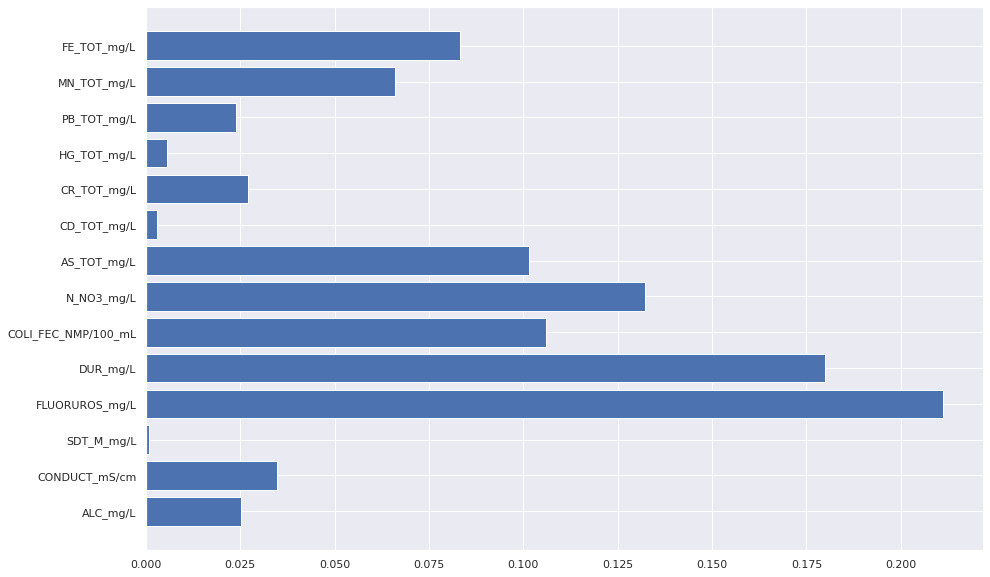

In [119]:
plt.barh(X.columns, df_DTCimportance)
plt.show()

Por tanto, nuestras Columnas de mayor importancia serán:
- AS_TOT_mg/L
- N_NO3_mg/L
- COLI_FEC_NMP/100_mL
- DUR_mg/L
- FLUORUROS_mg/L

Con esto en mente, vamos a tomar solo esas columnas y haremos nuestros grupos e datos para entrenamiento y pruebas.

In [120]:
X_slim = X.drop(['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'CD_TOT_mg/L',
       'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L',
       'FE_TOT_mg/L'], axis=1)
X_slim.columns #X con las columnas de mayor importancia

Index(['FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L',
       'AS_TOT_mg/L'],
      dtype='object')

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_slim, Y_Encoded, test_size=0.2, random_state=0, stratify=Y_Encoded)
X_train.shape,y_train.shape

((843, 5), (843,))

Para el siguiente paso, compararemos los Modelos DecisionTree y RandomForest. Para segurarnos 

In [131]:
from sklearn.ensemble import RandomForestClassifier

#Definimos nuestros modelos
DTmodel = DecisionTreeClassifier()
RFmodel = RandomForestClassifier()

DTmodel.fit(X_train,y_train)
RFmodel.fit(X_train,y_train)



RandomForestClassifier()

In [132]:
y_pred_dt = DTmodel.predict(X_train)

In [133]:
y_pred_rf = RFmodel.predict(X_train)

In [135]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Errores DecisionTree
print("**** DecisionTree Errors ****")
print("Metrica Accuracy: " + str(accuracy_score(y_train, y_pred_dt)))
print("Metrica precision: " + str(precision_score(y_train, y_pred_dt,average="micro")))
print("Metrica F1: " + str(f1_score(y_train, y_pred_dt, average="micro")))
print("Metrica Recall: " + str(recall_score(y_train, y_pred_dt, average="micro")))

**** DecisionTree Errors ****
Metrica Accuracy: 1.0
Metrica precision: 1.0
Metrica F1: 1.0
Metrica Recall: 1.0


In [136]:
# Errores RandomForest
print("**** RandomForest Errors ****")
print("Metrica Accuracy: " + str(accuracy_score(y_train, y_pred_rf)))
print("Metrica precision: " + str(precision_score(y_train, y_pred_rf,average="micro")))
print("Metrica F1: " + str(f1_score(y_train, y_pred_rf,average="micro")))
print("Metrica Recall: " + str(recall_score(y_train, y_pred_rf,average="micro")))

**** RandomForest Errors ****
Metrica Accuracy: 1.0
Metrica precision: 1.0
Metrica F1: 1.0
Metrica Recall: 1.0


Al parecer nuestros modelos con los parámetros por defecto s sobre-entrenan.
Vamos a ver que para cuando probamos con los datos de prueba

In [137]:
y_pred_test_dt = DTmodel.predict(X_test)
y_pred_test_rf = RFmodel.predict(X_test)

In [139]:
# Errores DecisionTree
print("**** DecisionTree Errors ****")
print("Metrica Accuracy: " + str(accuracy_score(y_test, y_pred_test_dt)))
print("Metrica precision: " + str(precision_score(y_test, y_pred_test_dt,average="micro")))
print("Metrica F1: " + str(f1_score(y_test, y_pred_test_dt, average="micro")))
print("Metrica Recall: " + str(recall_score(y_test, y_pred_test_dt, average="micro")))
print("\n")
# Errores RandomForest
print("**** RandomForest Errors ****")
print("Metrica Accuracy: " + str(accuracy_score(y_test, y_pred_test_rf)))
print("Metrica precision: " + str(precision_score(y_test, y_pred_test_rf,average="micro")))
print("Metrica F1: " + str(f1_score(y_test, y_pred_test_rf,average="micro")))
print("Metrica Recall: " + str(recall_score(y_test, y_pred_test_rf,average="micro")))

**** DecisionTree Errors ****
Metrica Accuracy: 0.8436018957345972
Metrica precision: 0.8436018957345972
Metrica F1: 0.8436018957345972
Metrica Recall: 0.8436018957345972


**** RandomForest Errors ****
Metrica Accuracy: 0.8815165876777251
Metrica precision: 0.8815165876777251
Metrica F1: 0.8815165876777251
Metrica Recall: 0.8815165876777251


Pues, al parecer nuestros modelos sí caen en su desempeño cuando los probamos con los datos de prueba. Pero con una exactitud de 84% para DT y 88% para RF, no podemos decir que están tan mal.

Vamos a realizar el reporte:

In [140]:
from sklearn.metrics import classification_report
#Reporte de DT
target_names = ['Verde', 'Amarillo', 'Rojo']
print(classification_report(y_test, y_pred_test_dt, target_names=target_names))

              precision    recall  f1-score   support

       Verde       0.75      0.67      0.71        49
    Amarillo       0.88      0.95      0.91        76
        Rojo       0.86      0.85      0.85        86

    accuracy                           0.84       211
   macro avg       0.83      0.82      0.82       211
weighted avg       0.84      0.84      0.84       211



In [141]:
#Reporte para RF
print(classification_report(y_test, y_pred_test_rf, target_names=target_names))

              precision    recall  f1-score   support

       Verde       0.88      0.73      0.80        49
    Amarillo       0.97      0.92      0.95        76
        Rojo       0.82      0.93      0.87        86

    accuracy                           0.88       211
   macro avg       0.89      0.86      0.87       211
weighted avg       0.89      0.88      0.88       211



Vamos a Revizar la Matriz de Confusión:

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Matris de Confucisión para DT
matrix_dt = confusion_matrix(y_test, y_pred_test_dt)
matrix_dt

array([[33,  5, 11],
       [ 3, 72,  1],
       [ 8,  5, 73]])

In [150]:
matrix_rf = confusion_matrix(y_test, y_pred_test_rf)
matrix_rf

array([[36,  0, 13],
       [ 1, 70,  5],
       [ 4,  2, 80]])

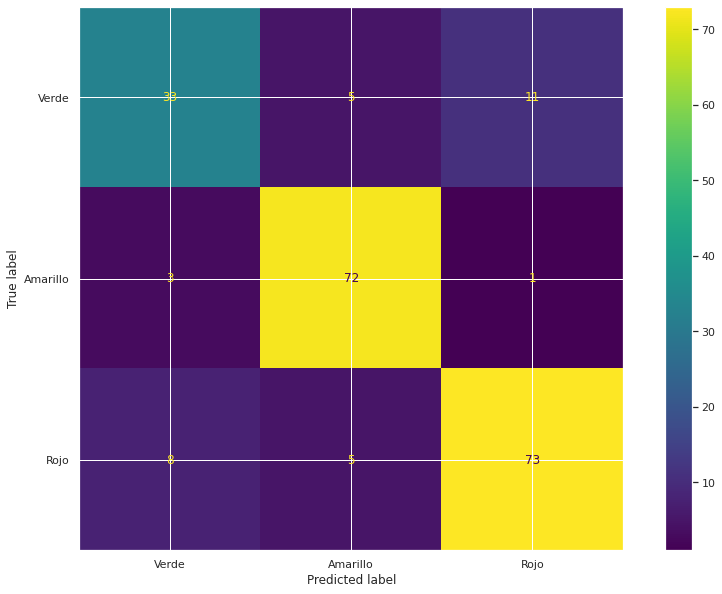

In [154]:
#DT plot
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix = matrix_dt, display_labels = Label_clases )

cm_display_dt.plot()
plt.show()

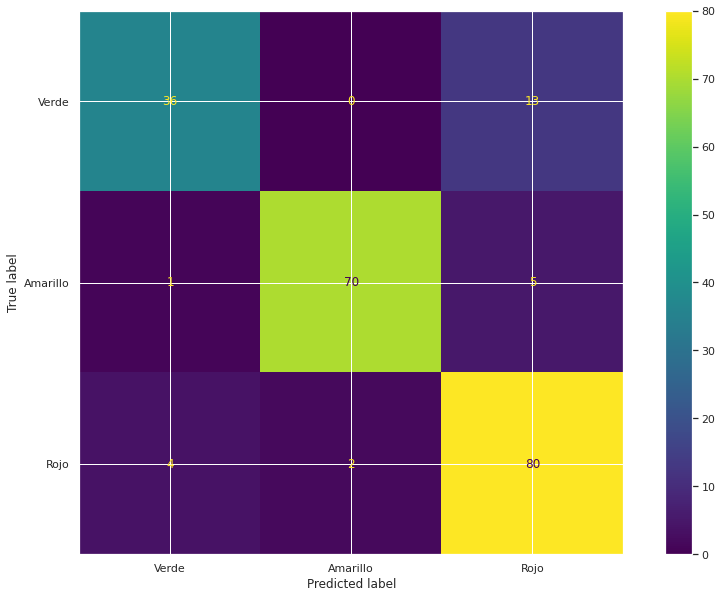

In [155]:
#RF plot
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix = matrix_rf, display_labels = Label_clases )

cm_display_rf.plot()
plt.show()

Vemos que el modelo de random forest es superior al Decision Tree. Aunque se recomienda realizar una búsqueda de hiperparámetros para que los modelos no se sobre-entrenen.